In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/normalizing-flows"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/normalizing-flows


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from flows import Flow
from flows.affine import Planar, Radial
from flows.sylvester import TriangularSylvester
from models.vae import GatedConvVAE

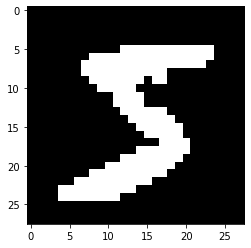

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train > 0).astype(np.float32)
X_test = (X_test > 0).astype(np.float32)
plt.imshow(X_train[0], cmap='gray')
x_train = np.expand_dims(X_train, axis=-1)
x_test = np.expand_dims(X_test, axis=-1)

In [3]:
def sample_digits_by_class(X, y, samples_per_class=1, classes=list(range(10))):
    samples = []
    labels = []
    for c in classes:
        match_inds = np.where(y.squeeze() == c)[0]
        sample_inds = np.random.choice(match_inds, size=samples_per_class, replace=False)
        samples.append(X[sample_inds])
        labels.append(y[sample_inds])
    return np.concatenate(samples, axis=0), np.concatenate(labels, axis=0)

In [4]:
def plot_images(x_test, x_pred):
    plt.subplot(2,4,1)
    plt.imshow(x_test[0], cmap='gray')
    plt.subplot(2,4,2)
    plt.imshow(x_test[1], cmap='gray')
    plt.subplot(2,4,3)
    plt.imshow(x_test[2], cmap='gray')
    plt.subplot(2,4,4)
    plt.imshow(x_test[3], cmap='gray')
    plt.subplot(2,4,5)
    plt.imshow(x_pred[0].squeeze(), cmap='gray')
    plt.subplot(2,4,6)
    plt.imshow(x_pred[1].squeeze(), cmap='gray')
    plt.subplot(2,4,7)
    plt.imshow(x_pred[2].squeeze(), cmap='gray')
    plt.subplot(2,4,8)
    plt.imshow(x_pred[3].squeeze(), cmap='gray')
    plt.show()

In [54]:
def plot_transforms(X, labels, vae, samples_per_input=1):
    num_transforms = vae.flow.num_flows + 1 if vae.flow is not None else 1
    _, zs = vae.sample(X, n=samples_per_input)
    assert len(zs) == num_transforms, 'expected {} z transforms, got {}'.format(num_transforms, len(zs))
    fig, axs = plt.subplots(1, num_transforms, figsize=(8*num_transforms,6))
    for i, z in enumerate(zs):
        ax = axs[i] if num_transforms > 1 else axs
        splot = ax.scatter(z[:,0], z[:,1], c=labels, cmap='tab10')
        ax.set_title('$z_{}$'.format(i))
    unique_labels = np.unique(labels)
    plt.figlegend(*splot.legend_elements(), loc = 'lower center', ncol=len(unique_labels), labelspacing=0.)
    return fig

def plot_tsne_transforms(X, labels, vae, samples_per_input=1):
    from sklearn.manifold import TSNE
    from tqdm import tqdm
    num_transforms = vae.flow.num_flows + 1 if vae.flow is not None else 1
    _, zs = vae.sample(X, n=samples_per_input)
    assert len(zs) == num_transforms, 'expected {} z transforms, got {}'.format(num_transforms, len(zs))
    if samples_per_input > 0:
        labels = np.repeat(labels, samples_per_input, axis=0)
    fig, axs = plt.subplots(1, num_transforms, figsize=(8*num_transforms,6))
    tsne = TSNE(n_components=2, perplexity=10)
    for i, z in tqdm(list(enumerate(zs)), desc='transforms'):
        ax = axs[i] if num_transforms > 1 else axs
        z_tsne = tsne.fit_transform(z)
        splot = ax.scatter(z_tsne[:,0], z_tsne[:,1], c=labels, cmap='tab10')
        ax.set_title('t-SNE mapped $z_{}$'.format(i))
    unique_labels = np.unique(labels)
    plt.figlegend(*splot.legend_elements(), loc = 'lower center', ncol=len(unique_labels), labelspacing=0.)
    return fig

In [6]:
def train_vae(x_train, x_test, flow=None, z_size=32, n_epochs=10):
    beta_update = lambda i, beta: 1.0E-1*(i+1)
    vae = GatedConvVAE(x_train.shape[1], x_train.shape[2], flow, z_size=z_size, beta_update_fn=beta_update)
    vae.fit(x_train, x_train, epochs=n_epochs, batch_size=128, validation_data=(x_test, x_test))
    return vae

In [7]:
# sample balanced set of digits for transform plots
X_samples, y_samples = sample_digits_by_class(x_test, y_test, samples_per_class=100)

### Vanilla VAE

In [8]:
vae = train_vae(x_train, x_test, z_size=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 186us/sample - loss: 0.3166 - val_loss: 0.2633
Epoch 2/10
60000/60000 [==============================] - 6s 103us/sample - loss: 0.2535 - val_loss: 0.2442
Epoch 3/10
60000/60000 [==============================] - 6s 104us/sample - loss: 0.2410 - val_loss: 0.2347
Epoch 4/10
60000/60000 [==============================] - 6s 104us/sample - loss: 0.2319 - val_loss: 0.2258
Epoch 5/10
60000/60000 [==============================] - 6s 104us/sample - loss: 0.2239 - val_loss: 0.2185
Epoch 6/10
60000/60000 [==============================] - 6s 106us/sample - loss: 0.2179 - val_loss: 0.2139
Epoch 7/10
60000/60000 [==============================] - 6s 104us/sample - loss: 0.2130 - val_loss: 0.2100
Epoch 8/10
60000/60000 [==============================] - 6s 104us/sample - loss: 0.2092 - val_loss: 0.2062
Epoch 9/10
60000/60000 [==============================] - 6s 103us/sample - loss: 0.2

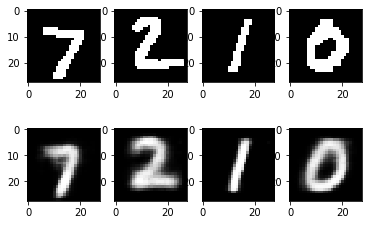

In [9]:
x_pred = vae.predict(x_test)
plot_images(x_test.squeeze(), x_pred)

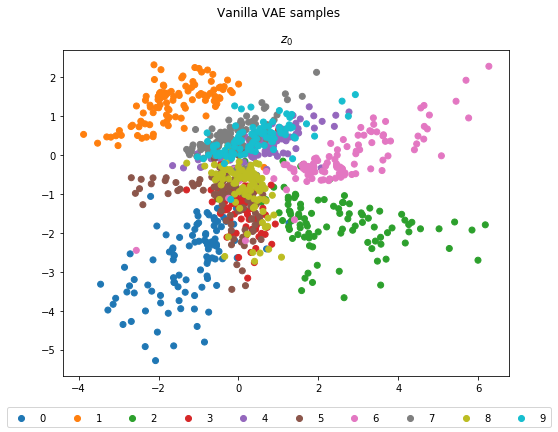

In [12]:
plot_transforms(X_samples, y_samples, vae)
plt.suptitle('Vanilla VAE samples')
plt.show()

### Planar VAE

In [13]:
n_flows = 4
planar_flow = Flow(n_flows, lambda i: Planar())
planar_vae = train_vae(x_train, x_test, planar_flow, z_size=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 194us/sample - loss: 0.3156 - val_loss: 0.2672
Epoch 2/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2558 - val_loss: 0.2476
Epoch 3/10
60000/60000 [==============================] - 7s 123us/sample - loss: 0.2431 - val_loss: 0.2385
Epoch 4/10
60000/60000 [==============================] - 7s 123us/sample - loss: 0.2311 - val_loss: 0.2250
Epoch 5/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2207 - val_loss: 0.2154
Epoch 6/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2156 - val_loss: 0.2120
Epoch 7/10
60000/60000 [==============================] - 7s 123us/sample - loss: 0.2116 - val_loss: 0.2084
Epoch 8/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2082 - val_loss: 0.2065
Epoch 9/10
60000/60000 [==============================] - 7s 123us/sample - loss: 0.2

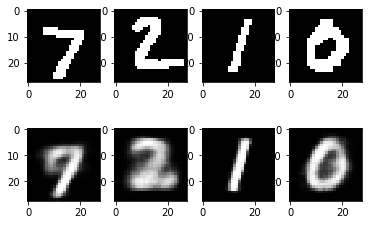

In [14]:
x_test = np.expand_dims(X_test, axis=-1)
x_pred = planar_vae.predict(x_test)
plot_images(x_test.squeeze(), x_pred)

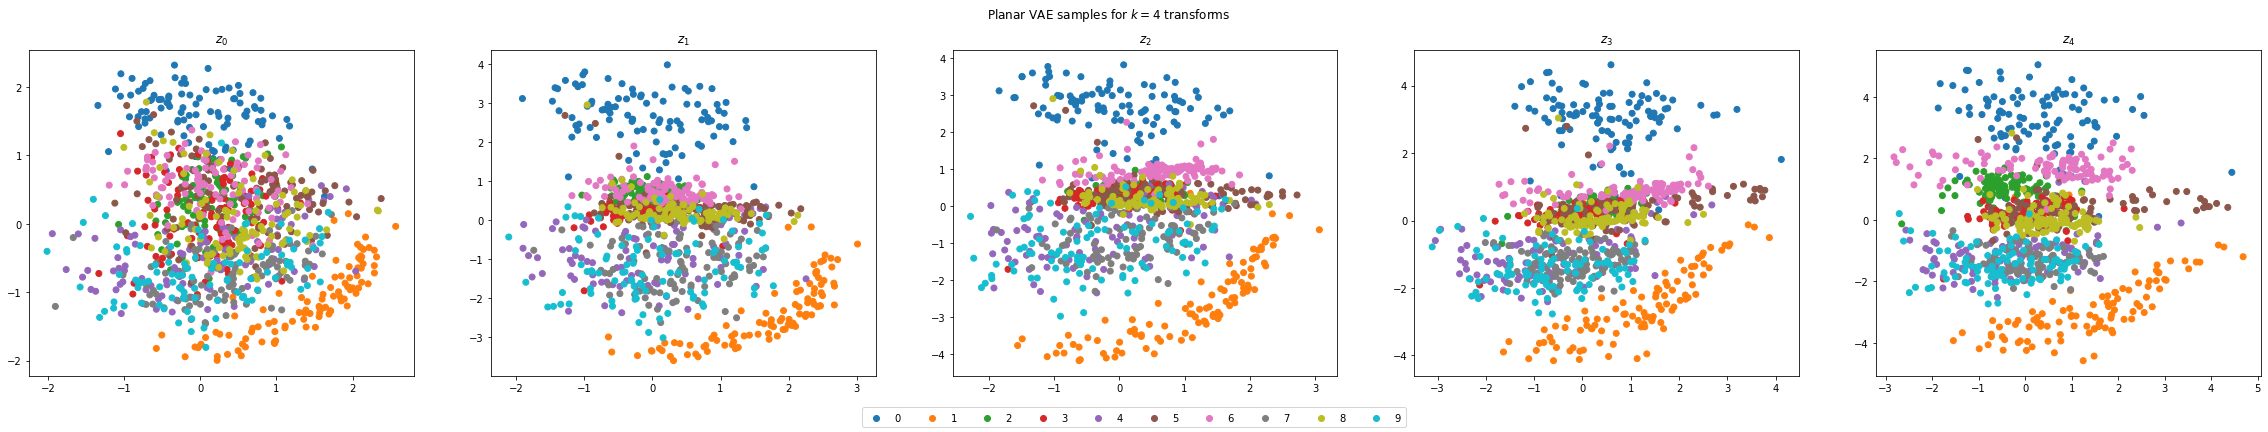

In [15]:
plot_transforms(X_samples, y_samples, planar_vae)
plt.suptitle('Planar VAE samples for $k={}$ transforms'.format(n_flows))
plt.show()

In [56]:
planar_vae_z32 = train_vae(x_train, x_test, planar_flow, z_size=32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 188us/sample - loss: 0.2036 - val_loss: 0.1373
Epoch 2/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.1289 - val_loss: 0.1205
Epoch 3/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.1178 - val_loss: 0.1130
Epoch 4/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.1126 - val_loss: 0.1095
Epoch 5/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.1089 - val_loss: 0.1061
Epoch 6/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.1063 - val_loss: 0.1046
Epoch 7/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.1041 - val_loss: 0.1020
Epoch 8/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.1015 - val_loss: 0.0992
Epoch 9/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0

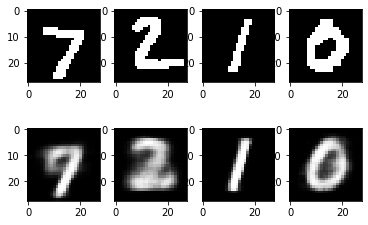

In [57]:
x_test = np.expand_dims(X_test, axis=-1)
x_pred = planar_vae.predict(x_test)
plot_images(x_test.squeeze(), x_pred)



transforms:   0%|          | 0/5 [00:00<?, ?it/s]

transforms:  20%|██        | 1/5 [00:04<00:16,  4.18s/it]

transforms:  40%|████      | 2/5 [00:08<00:12,  4.13s/it]

transforms:  60%|██████    | 3/5 [00:12<00:08,  4.06s/it]

transforms:  80%|████████  | 4/5 [00:15<00:03,  3.92s/it]

transforms: 100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


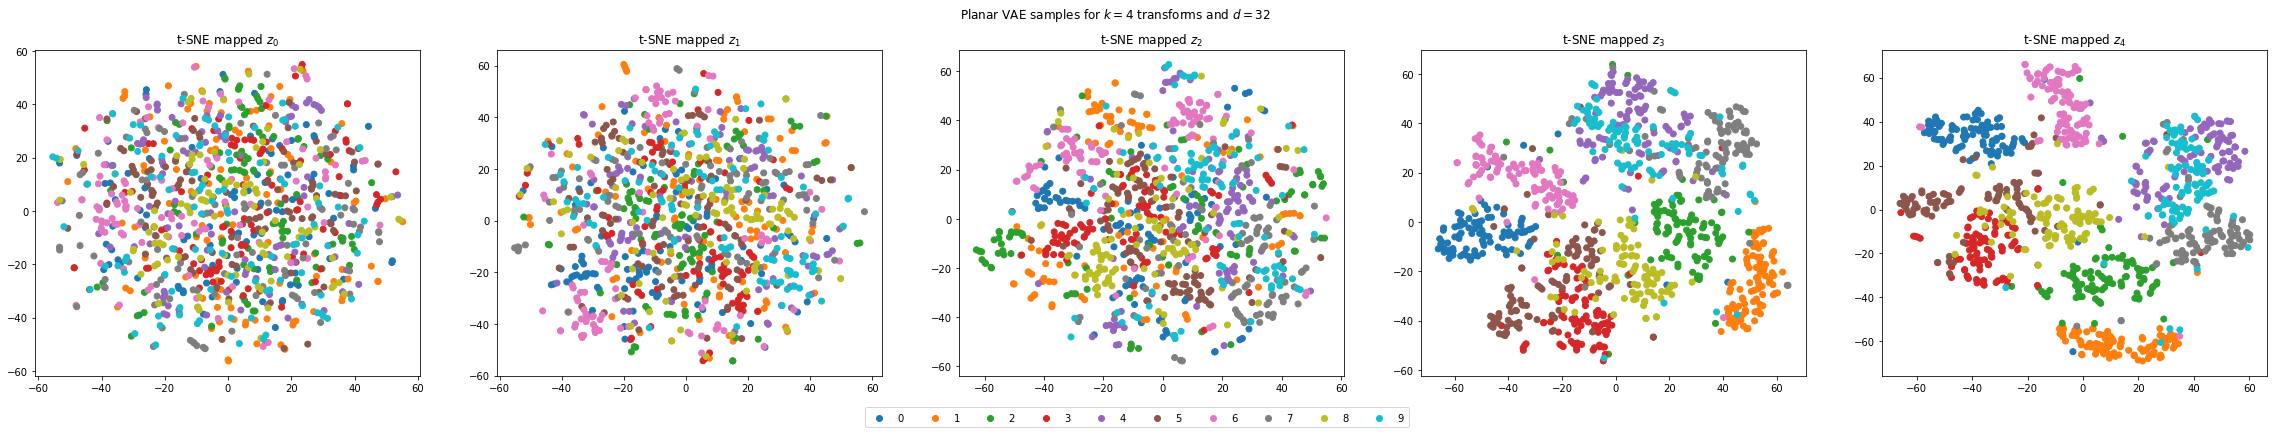

In [58]:
plot_tsne_transforms(X_samples, y_samples, planar_vae_z32)
plt.suptitle('Planar VAE samples for $k={}$ transforms and $d=32$'.format(n_flows))
plt.show()

### Triangular Sylvester VAE

In [16]:
n_flows = 4
tsnf_flow = Flow(n_flows, lambda i: TriangularSylvester(flip_z = i % 2 != 0))
tsnf_vae = train_vae(x_train, x_test, tsnf_flow, z_size=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 236us/sample - loss: 0.3078 - val_loss: 0.2575
Epoch 2/10
60000/60000 [==============================] - 9s 147us/sample - loss: 0.2508 - val_loss: 0.2436
Epoch 3/10
60000/60000 [==============================] - 9s 146us/sample - loss: 0.2372 - val_loss: 0.2287
Epoch 4/10
60000/60000 [==============================] - 9s 147us/sample - loss: 0.2247 - val_loss: 0.2172
Epoch 5/10
60000/60000 [==============================] - 9s 147us/sample - loss: 0.2153 - val_loss: 0.2091
Epoch 6/10
60000/60000 [==============================] - 9s 146us/sample - loss: 0.2087 - val_loss: 0.2053
Epoch 7/10
60000/60000 [==============================] - 9s 146us/sample - loss: 0.2047 - val_loss: 0.2022
Epoch 8/10
60000/60000 [==============================] - 9s 145us/sample - loss: 0.2021 - val_loss: 0.2004
Epoch 9/10
60000/60000 [==============================] - 9s 147us/sample - loss: 0.1

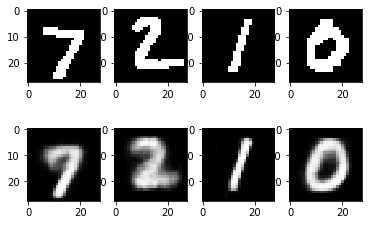

In [17]:
x_pred = tsnf_vae.predict(x_test)
plot_images(x_test.squeeze(), x_pred)

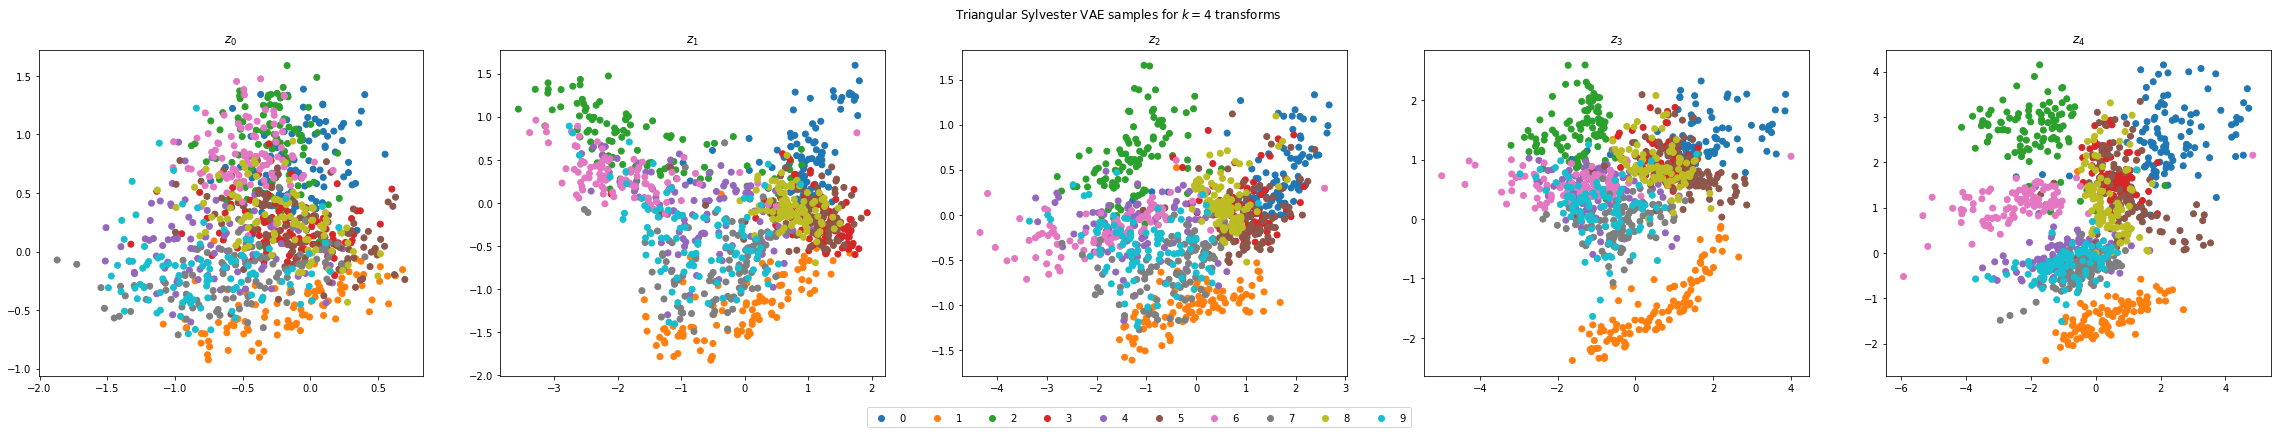

In [18]:
plot_transforms(X_samples, y_samples, tsnf_vae)
plt.suptitle('Triangular Sylvester VAE samples for $k={}$ transforms'.format(n_flows))
plt.show()

In [20]:
tsnf_vae_z32 = train_vae(x_train, x_test, tsnf_flow, z_size=32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 235us/sample - loss: 0.1847 - val_loss: 0.1222
Epoch 2/10
60000/60000 [==============================] - 10s 160us/sample - loss: 0.1150 - val_loss: 0.1075
Epoch 3/10
60000/60000 [==============================] - 10s 160us/sample - loss: 0.1044 - val_loss: 0.1000
Epoch 4/10
60000/60000 [==============================] - 10s 159us/sample - loss: 0.0990 - val_loss: 0.0961
Epoch 5/10
60000/60000 [==============================] - 10s 159us/sample - loss: 0.0958 - val_loss: 0.0939
Epoch 6/10
60000/60000 [==============================] - 10s 159us/sample - loss: 0.0935 - val_loss: 0.0922
Epoch 7/10
60000/60000 [==============================] - 10s 159us/sample - loss: 0.0917 - val_loss: 0.0902
Epoch 8/10
60000/60000 [==============================] - 10s 159us/sample - loss: 0.0904 - val_loss: 0.0893
Epoch 9/10
60000/60000 [==============================] - 10s 160us/sample - l

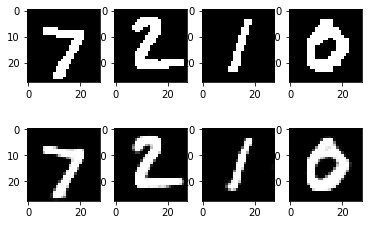

In [21]:
x_pred = tsnf_vae_z32.predict(x_test)
plot_images(x_test.squeeze(), x_pred)



transforms:   0%|          | 0/5 [00:00<?, ?it/s]

transforms:  20%|██        | 1/5 [00:04<00:16,  4.03s/it]

transforms:  40%|████      | 2/5 [00:07<00:12,  4.00s/it]

transforms:  60%|██████    | 3/5 [00:11<00:07,  3.98s/it]

transforms:  80%|████████  | 4/5 [00:15<00:03,  3.93s/it]

transforms: 100%|██████████| 5/5 [00:19<00:00,  3.92s/it]


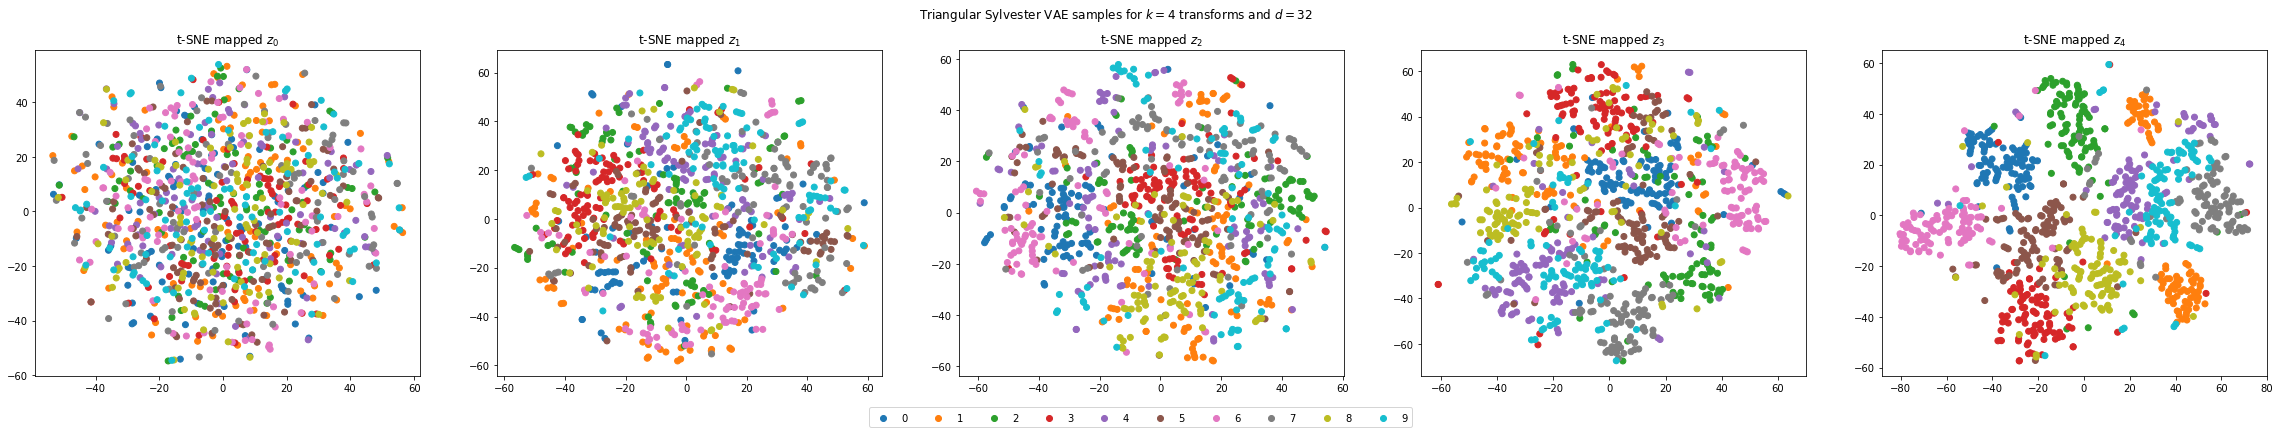

In [55]:
plot_tsne_transforms(X_samples, y_samples, tsnf_vae_z32)
plt.suptitle('Triangular Sylvester VAE samples for $k={}$ transforms and $d=32$'.format(n_flows))
plt.show()